In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
from keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TerminateOnNaN
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

np.random.seed(42)
tf.random.set_seed(42)
seed = 42

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [2]:
data = np.load("/kaggle/input/an2dl-hw22024-2025/flippedx4_no_aliens.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

# Shuffle X_train and y_train while preserving correspondence
X_train, y_train = shuffle(X_train, y_train, random_state=seed)

X_test = data["test_set"]

num_classes = len(np.unique(y_train))

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")
print(f"Number of classes: {num_classes}")

Training X shape: (10020, 64, 128)
Training y shape: (10020, 64, 128)
Test X shape: (10022, 64, 128)
Number of classes: 5


In [3]:
# Compute pixel distribution per class
unique_classes, class_pixel_counts = np.unique(y_train, return_counts=True)
total_pixels = sum(class_pixel_counts)

# Compute inverse frequency
class_weights = 1e6 / (class_pixel_counts + 1e-6)
class_weights[0] = 0 # to make so 'Background' class is not predicted
print(class_weights)

[0.         0.03593225 0.05233618 0.06629852 9.27196529]


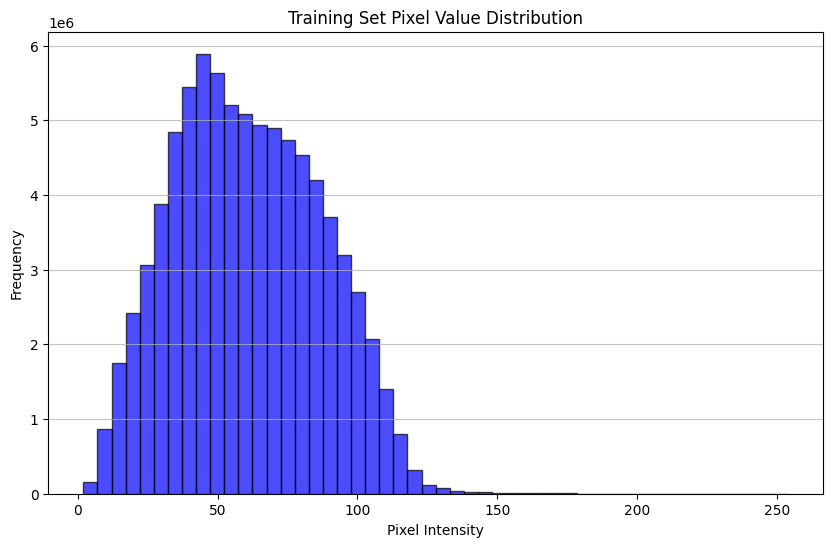

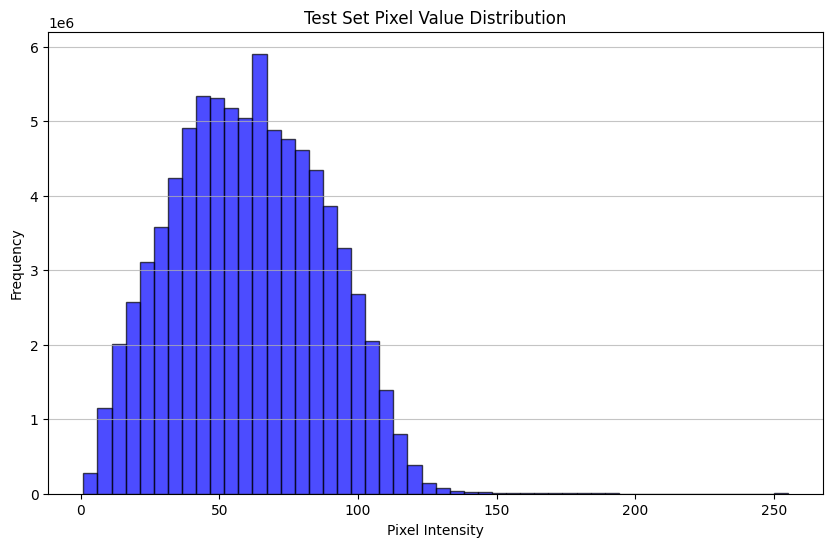

In [4]:
def plot_histogram(data, title="Pixel Value Distribution", bins=50):
    # Flatten the data to a 1D array for the histogram
    flat_data = data.flatten()
    
    plt.figure(figsize=(10, 6))
    plt.hist(flat_data, bins=bins, color='blue', edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Check that histograms are similar and training data is not altered
plot_histogram(X_train, title="Training Set Pixel Value Distribution")
plot_histogram(X_test, title="Test Set Pixel Value Distribution")

In [5]:
# Compute pixel distribution for each class
unique_classes, class_pixel_counts = np.unique(y_train, return_counts=True)
total_pixels = sum(class_pixel_counts)

for cls, count in zip(unique_classes, class_pixel_counts):
    percentage = (count / total_pixels) * 100
    print(f"Class {cls}: {count} pixel ({percentage:.2f}%)")

Class 0.0: 19955304 pixel (24.31%)
Class 1.0: 27830152 pixel (33.90%)
Class 2.0: 19107240 pixel (23.28%)
Class 3.0: 15083292 pixel (18.38%)
Class 4.0: 107852 pixel (0.13%)


In [6]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x
    
def residual_block(input_tensor, filters, kernel_size=3, activation='relu', name=''):
    """Residual block with convolutional layers and a shortcut connection."""
    x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv1')(input_tensor)
    x = tfkl.BatchNormalization(name=name + 'bn1')(x)
    x = tfkl.Activation(activation, name=name + 'activation1')(x)

    x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv2')(x)
    x = tfkl.BatchNormalization(name=name + 'bn2')(x)

    shortcut = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + 'shortcut')(input_tensor)
    x = tfkl.Add(name=name + 'add')([x, shortcut])
    x = tfkl.Activation(activation, name=name + 'activation2')(x)

    return x

def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck with Residual Path
    bottleneck_main = unet_block(d3, 256, name='bottleneck_main')
    bottleneck_residual = residual_block(d3, 256, name='bottleneck_residual')
    bottleneck = tfkl.Add(name='bottleneck_add')([bottleneck_main, bottleneck_residual])

    # Upsampling path with transposed convolutions
    u1 = tfkl.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same', name='up_conv1')(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, 128, name='up_block1_')

    u2 = tfkl.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same', name='up_conv2')(u1)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u3 = tfkl.Conv2DTranspose(32, kernel_size=2, strides=2, padding='same', name='up_conv3')(u2)
    u3 = tfkl.Add(name='skip_add')([u3, down_block_1])  # Use addition for lightweight feature merging
    u3 = unet_block(u3, 32, name='up_block3_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Enhanced_UNet')
    
    return model


In [7]:
def multi_scale_path(input_tensor, filters, name='multi_scale_'):
    """Auxiliary path with dilated convolutions for multi-scale feature extraction."""
    d1 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=1, padding='same', name=name + 'dilated1')(input_tensor)
    d1 = tfkl.BatchNormalization(name=name + 'bn1')(d1)
    d1 = tfkl.Activation('relu', name=name + 'activation1')(d1)

    d2 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=2, padding='same', name=name + 'dilated2')(input_tensor)
    d2 = tfkl.BatchNormalization(name=name + 'bn2')(d2)
    d2 = tfkl.Activation('relu', name=name + 'activation2')(d2)

    d3 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=4, padding='same', name=name + 'dilated4')(input_tensor)
    d3 = tfkl.BatchNormalization(name=name + 'bn3')(d3)
    d3 = tfkl.Activation('relu', name=name + 'activation3')(d3)

    # Combine multi-scale features
    multi_scale_output = tfkl.Add(name=name + 'add')([d1, d2, d3])
    return multi_scale_output

def global_context_path(input_tensor, filters, name='global_context_'):
    """Auxiliary path for global context using Global Average Pooling."""
    global_avg = tfkl.GlobalAveragePooling2D(name=name + 'gap')(input_tensor)
    global_avg = tfkl.Dense(filters, activation='relu', name=name + 'dense')(global_avg)
    global_avg = tfkl.Reshape((1, 1, filters), name=name + 'reshape')(global_avg)

    # Broadcast global context back to spatial dimensions
    global_context = tfkl.Conv2D(filters, kernel_size=1, activation='relu', padding='same', name=name + 'conv')(global_avg)
    global_context = tfkl.UpSampling2D(size=(input_tensor.shape[1], input_tensor.shape[2]), interpolation='bilinear', name=name + 'upsample')(global_context)

    return global_context

def get_enriched_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=42):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck with Auxiliary Paths
    bottleneck_main = unet_block(d3, 256, name='bottleneck_main')
    bottleneck_residual = residual_block(d3, 32, name='bottleneck_residual')

    # Auxiliary Paths
    multi_scale_features = multi_scale_path(d3, 256, name='multi_scale_')
    global_context_features = global_context_path(d3, 32, name='global_context_')

    # Merge bottleneck and auxiliary features
    bottleneck = tfkl.Concatenate(name='bottleneck_add')([
        bottleneck_main,
        bottleneck_residual,
        multi_scale_features,
        global_context_features
    ])

        # Advanced Fusion Layer with Squeeze-and-Excitation Attention
    def squeeze_and_excite_block(input_tensor, reduction_ratio=16, name="se_block"):
        """Squeeze-and-Excitation Block for channel-wise attention."""
        channels = input_tensor.shape[-1]
        se = tfkl.GlobalAveragePooling2D(name=name + "_global_avg_pool")(input_tensor)
        se = tfkl.Dense(channels // reduction_ratio, activation='relu', name=name + "_dense1")(se)
        se = tfkl.Dense(channels, activation='sigmoid', name=name + "_dense2")(se)
        se = tfkl.Multiply(name=name + "_scale")([input_tensor, tfkl.Reshape((1, 1, channels))(se)])
        return se
    
    # Replace the original 1x1 convolution fusion layer
    fusion_layer = tfkl.Conv2D(bottleneck.shape[-1], kernel_size=3, activation='relu', padding='same', name='fusion_conv')(bottleneck)
    fusion_layer = squeeze_and_excite_block(fusion_layer, reduction_ratio=16, name="fusion_se")
    fusion_layer = tfkl.Add(name='fusion_residual')([bottleneck, fusion_layer])  # Residual connection


    # Upsampling path
    u1 = tfkl.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same', name='up_conv1')(fusion_layer)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, 128, name='up_block1_')

    u2 = tfkl.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same', name='up_conv2')(u1)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u3 = tfkl.Conv2DTranspose(32, kernel_size=2, strides=2, padding='same', name='up_conv3')(u2)
    u3 = tfkl.Add(name='skip_add')([u3, down_block_1])  # Use addition for lightweight feature merging
    u3 = unet_block(u3, 32, name='up_block3_')
    
    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Enriched_UNet')

    return model


In [8]:
class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, 
                 dice_weight=1.0, 
                 scce_weight=1.0, 
                 focal_weight=0.5, 
                 boundary_weight=1.0, 
                 class_weights=[1, 1, 1, 1, 1], 
                 gamma=2.0, 
                 smooth=1e-6, 
                 name="combined_loss"):
        super().__init__(name=name)
        self.dice_weight = dice_weight
        self.scce_weight = scce_weight
        self.focal_weight = focal_weight
        self.boundary_weight = boundary_weight
        self.class_weights = tf.constant(class_weights, dtype=tf.float32) if class_weights is not None else None
        self.gamma = gamma
        self.smooth = smooth
        self.scce = SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)

    def dice_loss(self, y_true, y_pred):
        """Compute Dice Loss."""
        num_classes = tf.shape(y_pred)[-1]
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)

        # Flatten the tensors
        y_true_flat = tf.reshape(y_true, [-1, num_classes])
        y_pred_flat = tf.reshape(y_pred, [-1, num_classes])

        # Compute intersection and union
        intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
        union = tf.reduce_sum(y_true_flat, axis=0) + tf.reduce_sum(y_pred_flat, axis=0)

        # Compute Dice coefficient for each class
        dice_coeff = (2. * intersection + self.smooth) / (union + self.smooth)

        if self.class_weights is not None:
            dice_coeff *= self.class_weights

        # Dice Loss
        return 1 - tf.reduce_mean(dice_coeff)

    def focal_loss(self, y_true, y_pred):
        """Compute Focal Loss."""
        num_classes = tf.shape(y_pred)[-1]
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)

        # Clip predictions to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())

        # Compute focal loss
        focal_loss = -y_true * tf.math.pow(1 - y_pred, self.gamma) * tf.math.log(y_pred)

        if self.class_weights is not None:
            focal_loss *= self.class_weights

        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    def call(self, y_true, y_pred):
        """Compute the combined loss."""
        # Sparse Categorical Crossentropy Loss
        scce_loss = tf.reduce_mean(self.scce(y_true, y_pred))

        # Dice Loss
        dice_loss = self.dice_loss(y_true, y_pred)

        # Focal Loss
        focal_loss = self.focal_loss(y_true, y_pred)

        # Combine all losses
        total_loss = (
            self.scce_weight * scce_loss +
            self.dice_weight * dice_loss +
            self.focal_weight * focal_loss
        )

        return total_loss

In [9]:
def build_and_train(**params):
    learning_rate = params["learning_rate"]
    batch_size = params["batch_size"]
    weight_decay = params["weight_decay"]
    

    model = get_enriched_unet_model()

    optimizer = tf.keras.optimizers.AdamW(learning_rate, weight_decay)
    loss = CombinedLoss(dice_weight=params["w_scce"], scce_weight=params["w_scce"], focal_weight=params["w_focal"], class_weights=class_weights, gamma=params["gamma_focal"])
    mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, name="mean_iou", ignore_class=0, sparse_y_pred=False)

    model.compile(optimizer=optimizer, loss=loss, metrics=[mean_iou])
    
    checkpoint_path = "/kaggle/working/model_checkpoint.keras"
    log_path = "/kaggle/working/training_log.csv"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=params["es_patience"], mode='min', verbose=1),
        ReduceLROnPlateau(factor=0.5, monitor='val_loss', patience=int(params["es_patience"] / 2), min_lr=5e-6, verbose=1, mode='min'),
        ModelCheckpoint(checkpoint_path, monitor='val_mean_iou', mode='max',verbose=1, save_best_only=True),
        CSVLogger(log_path, separator=',', append=True)
        #TerminateOnNaN()
    ]
    
    list_IDs = []
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=200, verbose=2, callbacks=callbacks, validation_split=0.2)
    model.load_weights(checkpoint_path)

    def best_metric(history, metric, mode='max'):
        values = history.history[metric]
        best_value = max(values) if mode == 'max' else min(values)
        return best_value
    
    # Example usage
    val_mean_iou = best_metric(history, 'val_mean_iou')
    print(f"Best val_mean_iou: {val_mean_iou:.4f}")
    
    return val_mean_iou, model

In [10]:
params = {
        "learning_rate": 1e-3,
        "batch_size": 128,
        "es_patience": 50,
        "weight_decay": 1e-3,
        "w_scce": 0.0,
        "w_dice": 0.4,
        "w_focal": 0.3,
        "gamma_focal": 0.5
            }

val_mean_iou, model = build_and_train(**params)
print(val_mean_iou)

Epoch 1/200


I0000 00:00:1734100741.511824      87 service.cc:145] XLA service 0x7da224049360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734100741.511901      87 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1734100742.874629      87 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734100763.695785      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1734100773.660692      89 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734100791.786165      87 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/


Epoch 1: val_mean_iou improved from -inf to 0.12570, saving model to /kaggle/working/model_checkpoint.keras
63/63 - 70s - 1s/step - loss: 0.0129 - mean_iou: 0.2311 - val_loss: 0.0242 - val_mean_iou: 0.1257 - learning_rate: 0.0010
Epoch 2/200

Epoch 2: val_mean_iou did not improve from 0.12570
63/63 - 10s - 159ms/step - loss: 0.0087 - mean_iou: 0.3405 - val_loss: 0.0684 - val_mean_iou: 0.0915 - learning_rate: 0.0010
Epoch 3/200

Epoch 3: val_mean_iou did not improve from 0.12570
63/63 - 10s - 158ms/step - loss: 0.0077 - mean_iou: 0.4463 - val_loss: 0.0732 - val_mean_iou: 0.0306 - learning_rate: 0.0010
Epoch 4/200

Epoch 4: val_mean_iou improved from 0.12570 to 0.32003, saving model to /kaggle/working/model_checkpoint.keras
63/63 - 10s - 166ms/step - loss: 0.0068 - mean_iou: 0.4702 - val_loss: 0.0141 - val_mean_iou: 0.3200 - learning_rate: 0.0010
Epoch 5/200

Epoch 5: val_mean_iou did not improve from 0.32003
63/63 - 10s - 159ms/step - loss: 0.0070 - mean_iou: 0.4575 - val_loss: 0.0171 

In [11]:
# Make predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step


In [12]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [13]:
# Create the csv submission file
submission_filename = f"submission.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

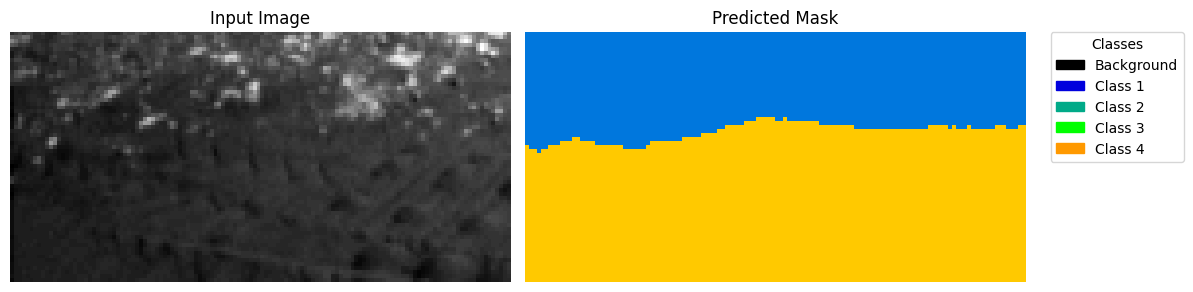

In [36]:
import matplotlib.patches as mpatches
import random

# Execute multiple times to have a visual understanding of the goodness of the predictions

def display_predictions_with_legend(images, predicted_masks, class_labels, num_samples=5):
    """
    Displays images and their predicted masks with a legend for class labels.

    Parameters:
        images (numpy array): Input images (e.g., X_test).
        predicted_masks (numpy array): Predicted masks from the model.
        class_labels (list): List of class labels (e.g., ['Background', 'Class 1', 'Class 2']).
        num_samples (int): Number of samples to display.
    """
    num_samples = min(num_samples, len(images))  # Ensure the number of samples doesn't exceed dataset size
    
    # Define a colormap for the legend
    num_classes = len(class_labels)
    colormap = plt.cm.nipy_spectral
    colors = [colormap(i / num_classes) for i in range(num_classes)]
    
    plt.figure(figsize=(12, 5 * num_samples))
    
    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title("Input Image")
        plt.axis('off')
        
        # Predicted mask
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(predicted_masks[i], cmap='nipy_spectral', vmin=0, vmax=num_classes - 1)
        plt.title("Predicted Mask")
        plt.axis('off')
        
        # Add legend for the first predicted mask only
        patches = [mpatches.Patch(color=colors[j], label=class_labels[j]) for j in range(num_classes)]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Classes")
    
    plt.tight_layout()
    plt.show()
    

# Example class labels (modify as per your dataset)
class_labels = ['Background', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
i = random.randint(1, 2000)

# Display predictions with legend
display_predictions_with_legend(X_test[i:], preds[i:], class_labels, num_samples=1)


In [15]:
# Compute pixel distribution per class
unique_classes, class_pixel_counts = np.unique(preds, return_counts=True)
total_pixels = sum(class_pixel_counts)

for cls, count in zip(unique_classes, class_pixel_counts):
    percentage = (count / total_pixels) * 100
    print(f"Classe {cls}: {count} pixel ({percentage:.2f}%)")

Classe 1: 27140535 pixel (33.06%)
Classe 2: 32668589 pixel (39.79%)
Classe 3: 22009854 pixel (26.81%)
Classe 4: 281246 pixel (0.34%)
